In [1]:
%matplotlib inline
import numpy as np
import pyfftw
from nbodykit.lab import *
from nbodykit import setup_logging, style
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from abacusnbody.data.compaso_halo_catalog import CompaSOHaloCatalog
import warnings
warnings.filterwarnings("ignore")
import pickle
from scipy.stats import poisson
from Corrfunc.theory import *
from astropy.cosmology import FlatLambdaCDM
from scipy.ndimage import convolve
from scipy.interpolate import interp1d
import sys
sys.path.append('../')
sys.path.append('../../')

In [2]:
from cosmology_functions import *

In [3]:
boxsize = 2000.
k0 = 2*np.pi/boxsize
z = 0.5
N0 = 6912
N = 1728
Nfiles = 34

In [4]:
z_init = 99

Dinit = calc_growthrate(z_init)
Dz = calc_growthrate(z)
Ddiff = Dz - Dinit
Dratio = Dz/Dinit

In [5]:
Rf = 2 # Gaussian smoothing
Nmesh = 400

In [6]:
# load in snapshot
cat = CompaSOHaloCatalog('/mnt/store2/bigsims/AbacusSummit/AbacusSummit_base_c000_ph006/halos/z0.500/',
                         fields=['N', 'x_com', 'r100_com'])
# cat = CompaSOHaloCatalog('/mnt/store2/bigsims/AbacusSummit/AbacusSummit_base_c000_ph006/halos/z0.500/',
#     fields=['N', 'x_com', 'r100_com', 'npstartA', 'npoutA'], load_subsamples='A_halo_rv')

In [8]:
# len(cat.subsamples)

3814722782

In [7]:
# the Zeldovich density field
deltaz = BigFileMesh(
    '/mnt/store2/xwu/AbacusSummit/base_c000_ph006/z%s_tilde_operators_nbody/deltaz_Nmesh%d_cic.bigfile'
    % (str(z), Nmesh), 'Field').compute()-1
dz_ = deltaz+1

In [8]:
# tilde delta1
td1 = BigFileMesh(
    '/mnt/store2/xwu/AbacusSummit/base_c000_ph006/z%s_tilde_operators_nbody/Rf%.3g/tsdelta1_Nmesh%d_cic.bigfile' % 
    (str(z), Rf, Nmesh),
    'Field').compute()*Dratio # not a great choice to multiply by Dratio...
td1_ = td1/dz_

### N > 150 halos

In [9]:
# galaxy-to-mass ratio
Nthres = 150
ii = cat.halos['N'] > Nthres

delta_h = ArrayCatalog({'Position': cat.halos[ii]['x_com'],
    'Value': cat.halos[ii]['N']}
    ).to_mesh(Nmesh=Nmesh, BoxSize=boxsize, resampler='cic').compute()
delta_h = delta_h / np.mean(delta_h) - 1.
deltak_h = pyfftw.interfaces.numpy_fft.rfftn(delta_h)
g2m = (delta_h+1)/dz_
# g2m_halocenter = (delta_h+1)/dz_

# pos = np.zeros((cat.halos[ii]['npoutA'].sum(),3))
# i = 0
# for halo in cat.halos[ii]:
#     if halo['npoutA'] > 0:
#         pos[i:i+halo['npoutA']] = cat.subsamples['pos'][halo['npstartA']:halo['npstartA']+halo['npoutA']]
#     i += halo['npoutA']
# delta_h = ArrayCatalog({'Position': pos}).to_mesh(Nmesh=Nmesh, BoxSize=boxsize, resampler='cic').compute()-1
# g2m_particles = (delta_h+1)/dz_

In [21]:
P_shot = boxsize**3/ii.sum()
kvec, Pk_h = calc_powerspectrum(deltak_h, boxsize)

#### differences of the using particles and using halo centers???

In [12]:
nbins = 30

bin_edges = np.histogram(np.reshape(td1_,-1), nbins)[1]
td1_bins = (bin_edges[1:] + bin_edges[:-1])/2
g2m_mean = [np.zeros(nbins), np.zeros(nbins)]
for i in range(nbins):
    ii = np.where((td1_>=bin_edges[i]) & (td1_<bin_edges[i+1]))
    if len(ii[0]) > 0:
        g2m_mean[0][i] = np.mean(g2m_halocenter[ii])
        g2m_mean[1][i] = np.mean(g2m_particles[ii])

Text(0.5, 0, '$k$')

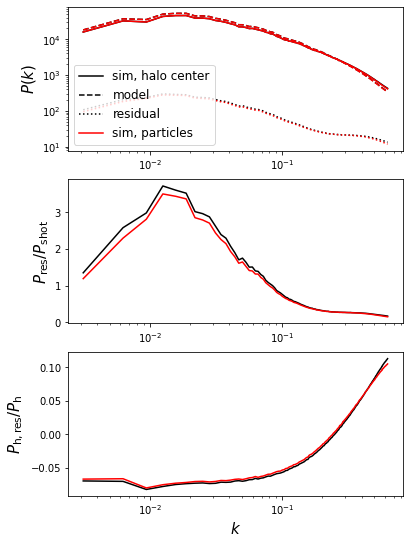

In [14]:
fig, axes = plt.subplots(figsize=(6, 9), nrows=3, ncols=1)

for i,c in enumerate(['k', 'r']):
    if i == 0:
        delta_h = g2m_halocenter*dz_-1
    else:
        delta_h = g2m_particles*dz_-1
    f = interp1d(td1_bins, g2m_mean[i], fill_value='extrapolate', bounds_error=False)
    delta_h_model = f(td1_)*dz_-1

    deltak_h = pyfftw.interfaces.numpy_fft.rfftn(delta_h)
    deltak_h_model = pyfftw.interfaces.numpy_fft.rfftn(delta_h_model)
    deltak_res = deltak_h-deltak_h_model

    kvec, Pk_h = calc_powerspectrum(deltak_h, boxsize)
    kvec, Pk_model = calc_powerspectrum(deltak_h_model, boxsize)
    kvec, Pk_res = calc_powerspectrum(deltak_res, boxsize)
    kvec, Pk_h_res = calc_powerspectrum(deltak_res, boxsize, grid2=deltak_h)

    if c == 'k':
        axes[0].loglog(kvec, Pk_h, c, label='sim, halo center')
        axes[0].plot(kvec, Pk_model, c, linestyle='--', label='model')
        axes[0].plot(kvec, Pk_res, c, linestyle=':', label='residual')
    else:
        axes[0].loglog(kvec, Pk_h, c, label='sim, particles')
        axes[0].plot(kvec, Pk_model, c, linestyle='--')
        axes[0].plot(kvec, Pk_res, c, linestyle=':')
    axes[1].semilogx(kvec, Pk_res/P_shot, c)
    axes[2].semilogx(kvec, Pk_h_res/Pk_h, c)
axes[0].set_ylabel(r'$P(k)$', fontsize=15)
axes[0].legend(fontsize=12)
axes[1].set_ylabel(r'$P_{\rm res}/P_{\rm shot}$', fontsize=15)
axes[2].set_ylabel(r'$P_{\rm h, res}/P_{\rm h}$', fontsize=15)
axes[-1].set_xlabel(r'$k$', fontsize=15)

(array([9.2097929e+07, 6.7872660e+06, 8.3857300e+05, 1.5812700e+05,
        3.2767000e+04, 6.5600000e+03, 1.2750000e+03, 2.2200000e+02,
        2.6000000e+01, 3.0000000e+00]),
 array([0.07873408, 0.36249226, 0.6462505 , 0.93000865, 1.2137668 ,
        1.4975251 , 1.7812833 , 2.0650415 , 2.3487997 , 2.6325579 ,
        2.916316  ], dtype=float32),
 <BarContainer object of 10 artists>)

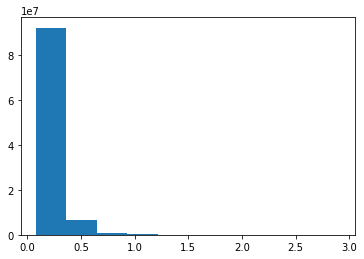

In [20]:
# halos are small?
Rhalo = cat.halos[cat.halos['N']>Nthres]['r100_com']
plt.hist(Rhalo)

#### galaxy-to-mass -- tilde delta1 relation

In [10]:
nbins = 30

bin_edges = np.histogram(np.reshape(td1_,-1), nbins)[1]
td1_bins = (bin_edges[1:] + bin_edges[:-1])/2
g2m_mean = np.zeros(nbins)
g2m_med = np.zeros(nbins)
g2m_hi = np.zeros(nbins)
g2m_lo = np.zeros(nbins)
for i in range(nbins):
    ii = np.where((td1_>=bin_edges[i]) & (td1_<bin_edges[i+1]))
    if len(ii[0]) > 0:
        g2m_mean[i] = np.mean(g2m[ii])
        g2m_med[i], g2m_lo[i], g2m_hi[i] = np.percentile(g2m[ii], [50, 32, 68])

(0.0, 4.0)

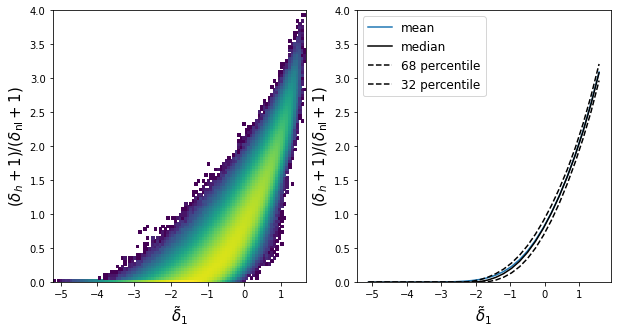

In [11]:
plt.figure(figsize=(10,5))
plt.subplot(121)
_ = plt.hist2d(np.reshape(td1_,-1), np.reshape(g2m,-1), bins=100, norm=LogNorm())
plt.xlabel(r'$\tilde{\delta}_1$', fontsize=15)
plt.ylabel(r'$(\delta_h+1)/(\delta_{\rm nl}+1)$', fontsize=15)
plt.ylim(0, 4)
plt.subplot(122)
plt.plot(td1_bins, g2m_mean, label='mean')
plt.plot(td1_bins, g2m_med, 'k', label='median')
plt.plot(td1_bins, g2m_hi, 'k--', label='68 percentile')
plt.plot(td1_bins, g2m_lo, 'k--', label='32 percentile')
plt.xlabel(r'$\tilde{\delta}_1$', fontsize=15)
plt.ylabel(r'$(\delta_h+1)/(\delta_{\rm nl}+1)$', fontsize=15)
plt.legend(fontsize=12)
plt.ylim(0, 4)

In [16]:
# see how the mean galaxy-to-mass -- \tilde\delta_1 relation recovers the true halo field
f = interp1d(td1_bins, g2m_mean, fill_value='extrapolate', bounds_error=False)
delta_h_model = f(td1_)*dz_-1
np.mean(delta_h_model)

-0.015715225

In [17]:
deltak_h_model = pyfftw.interfaces.numpy_fft.rfftn(delta_h_model)
deltak_res = deltak_h-deltak_h_model

In [19]:
kvec, Pk_model = calc_powerspectrum(deltak_h_model, boxsize)
kvec, Pk_res = calc_powerspectrum(deltak_res, boxsize)
kvec, Pk_h_res = calc_powerspectrum(deltak_res, boxsize, grid2=deltak_h)

Text(0.5, 0, '$k$')

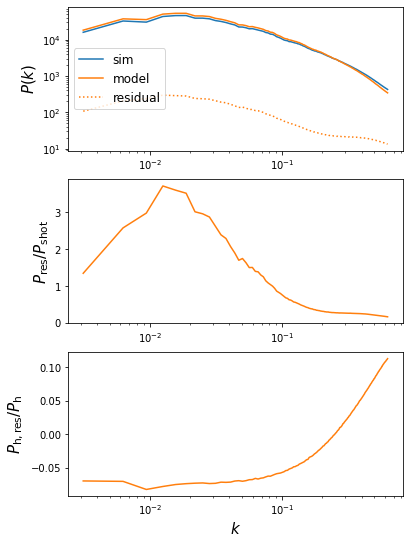

In [22]:
plt.figure(figsize=(6, 9))
plt.subplot(311)
plt.loglog(kvec, Pk_h, 'tab:blue', label='sim')
plt.plot(kvec, Pk_model, 'tab:orange', label='model')
plt.plot(kvec, Pk_res, 'tab:orange', linestyle=':', label='residual')
plt.ylabel(r'$P(k)$', fontsize=15)
plt.legend(fontsize=12)
plt.subplot(312)
plt.semilogx(kvec, Pk_res/P_shot, 'tab:orange')
plt.ylabel(r'$P_{\rm res}/P_{\rm shot}$', fontsize=15)
plt.subplot(313)
plt.semilogx(kvec, Pk_h_res/Pk_h, 'tab:orange')
plt.ylabel(r'$P_{\rm h, res}/P_{\rm h}$', fontsize=15)
plt.xlabel(r'$k$', fontsize=15)

Text(0.5, 0, '$k$')

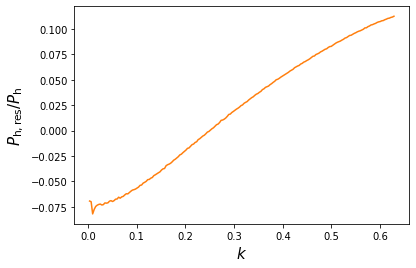

In [23]:
# does the last panel look like k^2
plt.plot(kvec, Pk_h_res/Pk_h, 'tab:orange')
plt.ylabel(r'$P_{\rm h, res}/P_{\rm h}$', fontsize=15)
plt.xlabel(r'$k$', fontsize=15)

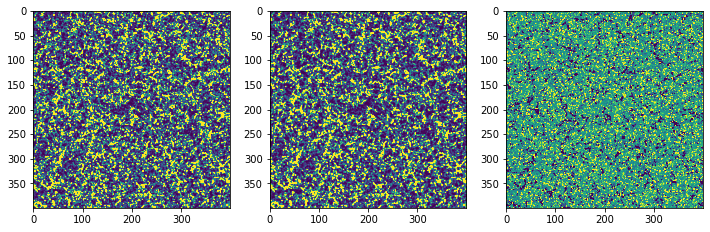

In [24]:
slc = 10
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(delta_h[:,:,slc], vmin=-1, vmax=1)
plt.subplot(132)
plt.imshow(delta_h_model[:,:,slc], vmin=-1, vmax=1)
plt.subplot(133)
plt.imshow(delta_h[:,:,slc] - delta_h_model[:,:,slc], vmin=-0.2, vmax=0.2)

#### contributions of other fields?

In [21]:
# load in other fields
tnabla2d1 = BigFileMesh(
    '/mnt/store2/xwu/AbacusSummit/base_c000_ph006/z%s_tilde_operators_nbody/Rf%.3g/tnabla2d1_Nmesh%d_cic.bigfile' % 
    (str(z), Rf, Nmesh), 'Field').compute()*Dratio
tnabla2d1_ = tnabla2d1/dz_

In [22]:
tG2 = BigFileMesh(
    '/mnt/store2/xwu/AbacusSummit/base_c000_ph006/z%s_tilde_operators_nbody/Rf%.3g/tG2_Nmesh%d_cic.bigfile' % 
    (str(z), Rf, Nmesh), 'Field').compute()*Dratio**2
tG2_ = tG2/dz_

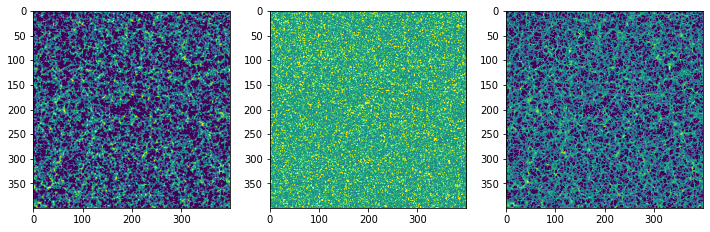

In [35]:
slc = 10
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(td1_[:,:,slc], vmin=-1, vmax=1)
plt.subplot(132)
plt.imshow(tnabla2d1_[:,:,slc], vmin=-0.2, vmax=0.2)
plt.subplot(133)
plt.imshow(tG2_[:,:,slc], vmin=-1, vmax=1)

In [23]:
# cross correlate with residual
kvec, Pk_z_res = calc_powerspectrum(deltak_res, boxsize, grid2=pyfftw.interfaces.numpy_fft.rfftn(deltaz))
kvec, Pk_tG2_res = calc_powerspectrum(deltak_res, boxsize, grid2=pyfftw.interfaces.numpy_fft.rfftn(tG2_))
kvec, Pk_tnabla2d1_res = calc_powerspectrum(deltak_res, boxsize, grid2=pyfftw.interfaces.numpy_fft.rfftn(tnabla2d1_))

In [24]:
kvec, Pk_z = calc_powerspectrum(pyfftw.interfaces.numpy_fft.rfftn(deltaz), boxsize)
kvec, Pk_tG2 = calc_powerspectrum(pyfftw.interfaces.numpy_fft.rfftn(tG2_), boxsize)
kvec, Pk_tnabla2d1 = calc_powerspectrum(pyfftw.interfaces.numpy_fft.rfftn(tnabla2d1_), boxsize)

Text(0.5, 0, '$k$')

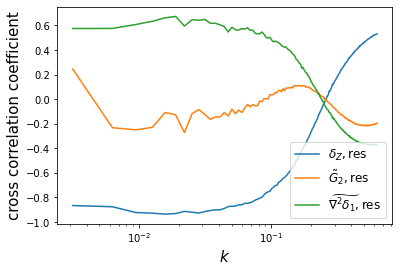

In [25]:
plt.semilogx(kvec, Pk_z_res/(Pk_z*Pk_res)**0.5, label=r'$\delta_Z,$res')
plt.semilogx(kvec, Pk_tG2_res/(Pk_tG2*Pk_res)**0.5, label=r'$\tilde{G}_2,$res')
plt.semilogx(kvec, Pk_tnabla2d1_res/(Pk_tnabla2d1*Pk_res)**0.5, label=r'$\widetilde{\nabla^2\delta_1},$res')
plt.legend(fontsize=12, loc=4)
plt.ylabel('cross correlation coefficient', fontsize=15)
plt.xlabel(r'$k$', fontsize=15)

In [26]:
# bin on both \tilde\delta_1 and G2
q1 = td1_
q2 = tG2_
_, x_edges, y_edges = np.histogram2d(np.reshape(q1,-1), np.reshape(q2,-1), bins=(25,20))
q1_bins = (x_edges[1:] + x_edges[:-1])/2
q2_bins = (y_edges[1:] + y_edges[:-1])/2
im_dh = np.zeros((len(q1_bins), len(q2_bins)))+np.nan
im_ncells = im_dh.copy()
for i in range(len(x_edges)-1):
    ii1 = np.where((q1 > x_edges[i]) & (q1 <= x_edges[i+1]))
    for j in range(len(y_edges)-1):
        ii2 = np.where((q2[ii1] > y_edges[j]) & (q2[ii1] < y_edges[j+1]))[0]
        if len(ii2) > 0:
            im_dh[i,j] = np.mean(g2m[ii1][ii2])
            im_ncells[i,j] = len(ii2)

Text(0, 0.5, '$\\tilde{G}_2$')

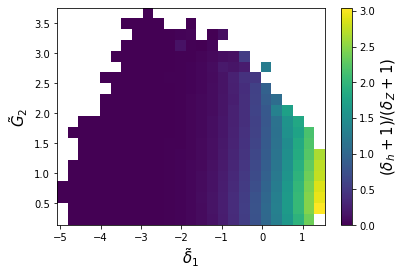

In [27]:
plt.imshow(im_dh.T, origin='lower', #norm=LogNorm(),
    extent=(q1_bins[0], q1_bins[-1], q2_bins[0], q2_bins[-1]), 
    aspect='auto')
# plt.imshow(im_ncells.T, origin='lower', norm=LogNorm())
cbar = plt.colorbar()
cbar.set_label(r'$(\delta_h+1)/(\delta_Z+1)$', fontsize=15)
plt.xlabel(r'$\tilde{\delta}_1$', fontsize=15)
plt.ylabel(r'$\tilde{G}_2$', fontsize=15)

In [28]:
# bin on both \tilde\delta_1 and nabla2d1
q1 = td1_
q2 = tnabla2d1_
_, x_edges, y_edges = np.histogram2d(np.reshape(q1,-1), np.reshape(q2,-1), bins=(25,20))
q1_bins = (x_edges[1:] + x_edges[:-1])/2
q2_bins = (y_edges[1:] + y_edges[:-1])/2
im_dh = np.zeros((len(q1_bins), len(q2_bins)))+np.nan
im_ncells = im_dh.copy()
for i in range(len(x_edges)-1):
    ii1 = np.where((q1 > x_edges[i]) & (q1 <= x_edges[i+1]))
    for j in range(len(y_edges)-1):
        ii2 = np.where((q2[ii1] > y_edges[j]) & (q2[ii1] < y_edges[j+1]))[0]
        if len(ii2) > 0:
            im_dh[i,j] = np.mean(g2m[ii1][ii2])
            im_ncells[i,j] = len(ii2)

Text(0, 0.5, '$\\widetilde{\\nabla^2\\delta_1}$')

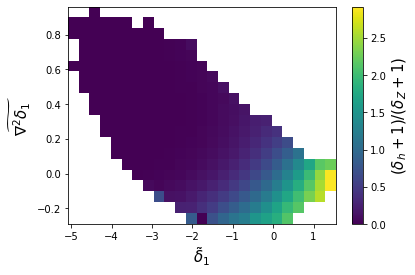

In [29]:
plt.imshow(im_dh.T, origin='lower', #norm=LogNorm(),
    extent=(q1_bins[0], q1_bins[-1], q2_bins[0], q2_bins[-1]), 
    aspect='auto')
# plt.imshow(im_ncells.T, origin='lower', norm=LogNorm())
cbar = plt.colorbar()
cbar.set_label(r'$(\delta_h+1)/(\delta_Z+1)$', fontsize=15)
plt.xlabel(r'$\tilde{\delta}_1$', fontsize=15)
plt.ylabel(r'$\widetilde{\nabla^2\delta_1}$', fontsize=15)

### other mass thresholds

In [11]:
Nthres_all = [150, 500, 1000, 3000]
g2m_all = [None]*len(Nthres_all)
for i,Nthres in enumerate(Nthres_all):
    ii = cat.halos['N'] > Nthres
    delta_h = ArrayCatalog({'Position': cat.halos[ii]['x_com'],
        'Value': cat.halos[ii]['N']}
        ).to_mesh(Nmesh=Nmesh, BoxSize=boxsize, resampler='cic').compute()
    g2m_all[i] = (delta_h / np.mean(delta_h)) / dz_

Text(0, 0.5, '$(\\delta_h+1)/(\\delta_Z+1)$')

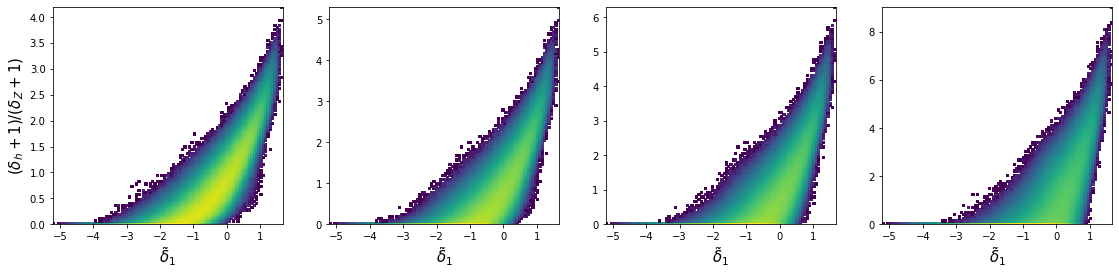

In [27]:
fig, axes = plt.subplots(figsize=(4*len(Nthres_all),4), nrows=1, ncols=len(Nthres_all))
fig.subplots_adjust(left=0.07, right=0.99)
for i in range(len(g2m_all)):
    _ = axes[i].hist2d(np.reshape(td1_,-1), np.reshape(g2m_all[i],-1), bins=100, norm=LogNorm())
    axes[i].set_xlabel(r'$\tilde{\delta}_1$', fontsize=15)
axes[0].set_ylabel(r'$(\delta_h+1)/(\delta_Z+1)$', fontsize=15)

In [12]:
nbins = 24
bin_edges = np.histogram(np.reshape(td1_,-1), nbins)[1]
td1_bins = (bin_edges[1:] + bin_edges[:-1])/2

(-3.0, 2.0)

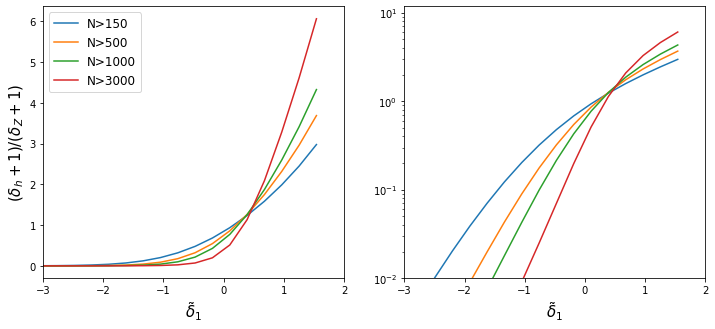

In [13]:
fig, axes = plt.subplots(figsize=(10,5), nrows=1, ncols=2)
fig.subplots_adjust(left=0.07, right=0.99)

g2m_mean_all = [None]*len(Nthres_all)
# g2m_med = np.zeros(nbins)
# g2m_hi = np.zeros(nbins)
# g2m_lo = np.zeros(nbins)
for j in range(len(g2m_all)):
    g2m_mean_all[j] = np.zeros(nbins)
    for i in range(nbins):
        ii = np.where((td1_>=bin_edges[i]) & (td1_<bin_edges[i+1]))
        if len(ii[0]) == 0:
            continue

        g2m_mean_all[j][i] = np.mean(g2m_all[j][ii])
#         g2m_med[i], g2m_lo[i], g2m_hi[i] = np.percentile(g2m_all[j][ii], [50, 32, 68])

    axes[0].plot(td1_bins, g2m_mean_all[j], label='N>%d' % Nthres_all[j])
#     if j == len(g2m_all)-1:
#         axes[0].plot(td1_bins, g2m_med, 'k', label='median N>%d' % Nthres_all[j])
#         axes[0].plot(td1_bins, g2m_hi, 'k--', label='68 percentile')
#         axes[0].plot(td1_bins, g2m_lo, 'k--', label='32 percentile')
#         axes[1].plot(td1_bins, g2m_med, 'k', label='median')

    axes[1].semilogy(td1_bins, g2m_mean_all[j], label='N>%d' % Nthres_all[j])

axes[0].set_xlabel(r'$\tilde{\delta}_1$', fontsize=15)
axes[0].set_ylabel(r'$(\delta_h+1)/(\delta_Z+1)$', fontsize=15)
axes[0].legend(fontsize=12)
axes[1].set_xlabel(r'$\tilde{\delta}_1$', fontsize=15)
axes[1].set_ylim(1e-2)
axes[0].set_xlim(-3, 2)
axes[1].set_xlim(-3, 2)

-0.018558584
80.06184937988294
-0.018759899
262.84293281721494
-0.017469937
537.0488881644696
-0.011858038
1811.1451078140724


(-0.1, 0.1)

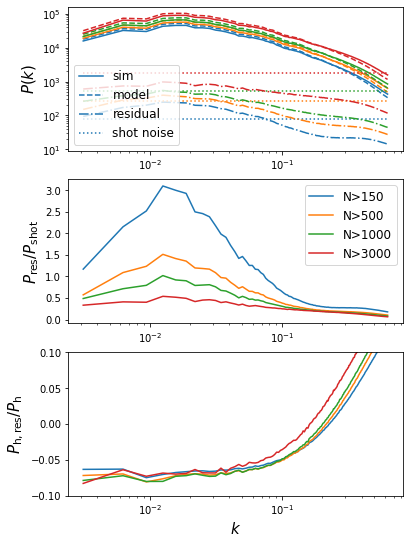

In [14]:
# see how the mean galaxy-to-mass -- \tilde\delta_1 relation recovers the true halo field
fig, axes = plt.subplots(figsize=(6, 9), nrows=3, ncols=1)
for j,color in zip(range(len(g2m_all)), ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']):
    f = interp1d(td1_bins, g2m_mean_all[j], fill_value='extrapolate', bounds_error=False)
    delta_h_model = f(td1_)*dz_-1
    print(np.mean(delta_h_model))

    delta_h = g2m_all[j]*dz_-1
    kvec, Pk_h = calc_powerspectrum(pyfftw.interfaces.numpy_fft.rfftn(delta_h), boxsize)
    kvec, Pk_model = calc_powerspectrum(pyfftw.interfaces.numpy_fft.rfftn(delta_h_model), boxsize)
    kvec, Pk_res = calc_powerspectrum(pyfftw.interfaces.numpy_fft.rfftn(delta_h-delta_h_model), boxsize)
    kvec, Pk_h_res = calc_powerspectrum(pyfftw.interfaces.numpy_fft.rfftn(delta_h-delta_h_model), boxsize,
                                   grid2=pyfftw.interfaces.numpy_fft.rfftn(delta_h))
    P_shot = boxsize**3/(cat.halos['N'] > Nthres_all[j]).sum()

    if j == 0:
        axes[0].loglog(kvec, Pk_h, color, label='sim')
        axes[0].plot(kvec, Pk_model, color, linestyle='--', label='model')
        axes[0].plot(kvec, Pk_res, color, linestyle='-.', label='residual')
        axes[0].semilogx(kvec, P_shot+kvec*0., color, linestyle=':', label='shot noise')
    else:
        axes[0].loglog(kvec, Pk_h, color)
        axes[0].plot(kvec, Pk_model, color, linestyle='--')
        axes[0].plot(kvec, Pk_res, color, linestyle='-.')
        axes[0].semilogx(kvec, P_shot+kvec*0., color, linestyle=':')
    axes[1].semilogx(kvec, Pk_res/boxsize**3*(cat.halos['N'] > Nthres_all[j]).sum(), color,
                    label='N>%d' % Nthres_all[j])
    print(P_shot)

    axes[2].semilogx(kvec, Pk_h_res/Pk_h, color)

axes[0].set_ylabel(r'$P(k)$', fontsize=15)
axes[0].legend(fontsize=12, loc=3)
axes[1].legend(fontsize=12, loc=1)
axes[1].set_ylabel(r'$P_{\rm res}/P_{\rm shot}$', fontsize=15)
axes[2].set_ylabel(r'$P_{\rm h, res}/P_{\rm h}$', fontsize=15)
axes[-1].set_xlabel(r'$k$', fontsize=15)
axes[-1].set_ylim(-0.1, 0.1)

Text(0.5, 0, '$n_{\\rm h} - n_{\\rm model}$')

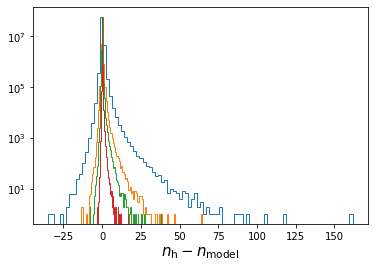

In [32]:
# histogram of the residuals... not much meaningful since we are using mass weighted halos?
for j in range(len(g2m_all)):
    mean_nh = (cat.halos['N'] > Nthres_all[j]).sum()/Nmesh**3
    f = interp1d(td1_bins, g2m_mean_all[j], fill_value='extrapolate', bounds_error=False)
    delta_h_model = f(td1_)*dz_-1

    delta_h = g2m_all[j]*dz_-1

    _ = plt.hist(np.reshape(delta_h-delta_h_model,-1)*mean_nh, 100, histtype='step')

plt.yscale('log')
plt.xlabel(r'$n_{\rm h} - n_{\rm model}$', fontsize=15)